# Nuclear Grades and Metastasis

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 10FEB2020 

_This is a static version of a Jupyter notebook, and work (documentation) is still in progress_ 
 
### Notebook Outline

1. [Load Data](#1)
2. [Functions](#2)
3. [Nuclear Grades](#3)
4. [Metastasis](#4)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import style
import scipy
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels as sms
from statsmodels.stats import multitest
from scipy.stats import shapiro
from decimal import Decimal
from statistics import mean
#For Seaborn plots
import seaborn as sns; sns.set(style='white')

#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk')

## 1. Load Data (all features)
<a id="1"></a>

In [2]:
RCCdataframe = pd.read_excel('data/RCCdataframe.xlsx')

Define features for RCC, numerical. 

In [30]:
df_features = RCCdataframe.drop(
    ['Groups', 'Collection', 'Sample ID', 'Metastatic', 
     'SubTypes','Nuclear Grade', 'Grade', 'Tstage', 
     'Tstage Group', 'Nstage', 'Mstage', 
     'Stage', 'Grouped Stage','Tumor Width','Gender', 
     'Race', 'BMI', 'Smoker', 'Age', 'Patient ID' ], axis=1)

## 2. Functions
<a id="2"></a>

__T-test function__

In [31]:
def Ttest(metabolites, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the metabolites differences between two groups with 
    Benjamini-Hocberg FDR correction
    
    Inputs: 
    metabolites = A list containing names of metabolites
    dfControl = A pandas dataframe containing the control group metabolites data
    dfTreat =  A pandas dataframe containing the treatment group metabolites data
    alpha = alpha for statistical significant judgment, default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    ttest_dict = {}
    for metabolite in metabolites:
        statistic, pvalue =  scipy.stats.ttest_ind(dfControl[metabolite], 
                                                   dfTreat[metabolite], 
                                                   equal_var=var)
        ttest_dict[metabolite] = pvalue 
        # a dictionary containing name of metabolites and p value after t-test
    ttest = pd.DataFrame.from_dict(ttest_dict, orient='index') # the dictionary in pandas df
    ttest_list=list(ttest_dict.values()) #values (pvalues) of ttest result in a list
    reject, pval_corrected, _, _ = sms.stats.multitest.multipletests(ttest_list, 
                                                                 alpha=alpha, 
                                                                 method='fdr_bh')
    ttest_results = pd.DataFrame({'Metabolite': metabolites, 'T-test p-value': ttest_list, 
                              'FDR p-value': pval_corrected, 'Reject H0': reject})
    Table = ttest_results.sort_values(by=['FDR p-value'])
    return Table

## 3. Nuclear Grades
<a id="3"></a>

In [32]:
RCCdataframe['Grade'].value_counts()

High    48
Low     30
Name: Grade, dtype: int64

In [6]:
Low = RCCdataframe[(RCCdataframe['Grade'] == 'Low')]
High = RCCdataframe[(RCCdataframe['Grade'] == 'High')]

_Welch t-test_

In [33]:
NG_ttest = Ttest(df_features.columns, Low, High, var=False) 
# T-test for difference between Low and High grades of cancer.
# '''List of Statistically relevant metabolites'''
# Select metabolites with <0.05 FDR
NGstat_sig = NG_ttest.loc[NG_ttest['Reject H0'] == True]

# Select metabolites with <0.05 t-test
#stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
print("The total number of significant metabolites/Features is: ", len(NGstat_sig))

The total number of significant metabolites/Features is:  0


## 4. Metastasis
<a id="4"></a>

In [34]:
RCCdataframe['Metastatic'].value_counts()

No     65
Yes    17
Name: Metastatic, dtype: int64

In [35]:
Yes = RCCdataframe[(RCCdataframe['Metastatic'] == 'Yes')]
No = RCCdataframe[(RCCdataframe['Metastatic'] == 'No')]

_Welch t-test_

In [36]:
MET_ttest = Ttest(df_features.columns, Yes, No, var=False) 
# T-test for difference between Low and High grades of cancer.
# '''List of Statistically relevant metabolites'''
# Select metabolites with <0.05 FDR
METstat_sig = MET_ttest.loc[MET_ttest['Reject H0'] == True]

# Select metabolites with <0.05 t-test
#stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
print("The total number of significant metabolites/Features is: ", len(METstat_sig))

The total number of significant metabolites/Features is:  5


In [37]:
METstat_sig

,Metabolite,T-test p-value,FDR p-value,Reject H0
848,849,0.000006,0.014116,True
1784,1785,0.000004,0.014116,True
856,857,0.000005,0.014116,True
1757,1758,0.000013,0.021847,True
1971,1972,0.000015,0.021847,True


In [39]:
# Import MS_labels
MS_labels = pd.read_excel('data/MS_labels.xlsx')

In [40]:
MS_labels[MS_labels.ID.isin(METstat_sig['Metabolite'])]

,ID,Mode,RT [min],Name,Formula
848,849,positive,1.815,thr-asp,C8 H14 N2 O6
856,857,positive,1.820,857,NaN
1757,1758,positive,2.132,δ-Valerolactam,C5 H9 N O
1784,1785,positive,0.835,1785,NaN
1971,1972,positive,2.086,Betaine,C5 H11 N O2


_Boxplot_

In [41]:
#Mfeatures is the dataframe for significant metabolites
Mfeatures = RCCdataframe[METstat_sig['Metabolite'].tolist()]
Mfeatures =(Mfeatures - Mfeatures.mean(axis=0))/Mfeatures.std(axis=0) #autoscaling

In [42]:
# index of metastasis in RCCdataframe
metas_loc = RCCdataframe.columns.get_loc("Metastatic") 
# marker is the dataframe for our boxplot
marker = RCCdataframe.iloc[:, metas_loc].to_frame().join(Mfeatures)
marker.head()

,Metastatic,849,1785,857,1758,1972
0,No,-0.366789,-0.202675,-0.049201,-0.897869,-0.884422
1,No,0.410060,-0.333574,0.516843,-0.091914,-0.051917
2,No,0.184681,-0.755913,0.623689,0.023429,0.776114
3,No,-0.533368,0.935587,-0.073577,-0.745396,-1.044624
4,Yes,-0.750384,-0.087995,-0.758476,-0.954328,-0.350824


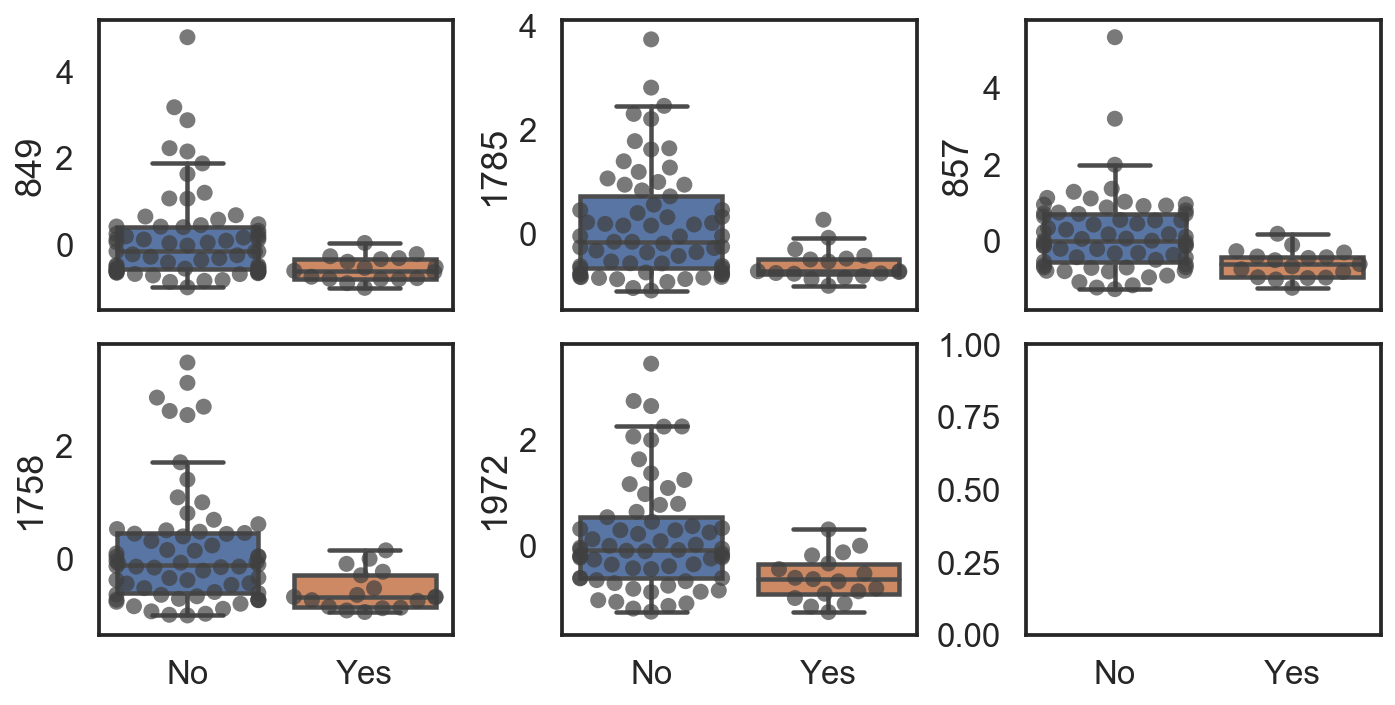

In [43]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(10, 5))
for idx, feat in enumerate(marker.columns[1:]):
    ax = axes[int(idx / 3), idx % 3]
    sns.boxplot(x='Metastatic', y=feat, data=marker, ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Metastatic', y=feat, data=marker, 
                  ax=ax, s=8, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('AUCplots.svg', dpi=300)